# <u>[Laptop Price Predictor](https://paras-rupani-laptop-price-predictor.streamlit.app)</u>

### Group - 6:
- ### Paras Rupani
- ### Sumit Sandhu

### Motivation:

- We all can agree that nobody likes to buy an overpriced item, especially when purchasing expensive items.

- Buyers need to ensure they get a good deal as laptops are essential assets and are not replaced frequently.

- Enabling users with a tool which predicts the price of a laptop would allow them to make an informed purchase decision.


### Goal: Estimating the Price of a Laptop when a user inputs their required specifications.

### Importing Required Libraries

In [1]:
# Libraries for data preprocessing and manipulating
import numpy as np
import pandas as pd
import re
from random import randint
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
plotly.offline.init_notebook_mode()

# Libraries for sklearn models and tools
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, VotingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVR
import xgboost as xgb
from xgboost import XGBRegressor


# Libraries for TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

# Miscellaneous
import joblib
import sys
import os
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

2024-04-17 02:06:13.694565: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-17 02:06:14.965342: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Reading the Dataset

### Approach

- **Initial Setup**: The code was initially designed to extract data for a single product by parsing the structured data provided by Amazon in a table format.

- **Expanding to Category Pages**: Later, the script was modified to extract product links from category pages, allowing for the extraction of multiple laptop products.

### Optimization

- **Parallel Execution**: To save time, you can execute multiple instances of the script simultaneously in different terminal windows. This allows you to scrape different categories or Amazon domains concurrently

### Challenges

- **Currency Symbol Handling**: The script needed to handle different currency symbols. To streamline the process, separate data files were created for each currency (INR, USD, CAD).

- **Uni-Code Handling**: The uni-code character `\u200e` indicating the text should be read from left to right was removed during data extraction.

### Currency Conversion

- Prices were converted to Canadian Dollars using conversion rates for INR and USD.
- Conversion rates used:
  - 1 INR = 0.016 CAD
  - 1 USD = 1.36 CAD

### Overcoming Anti-Scraping Measures on Amazon

- Amazon's anti-scraping defenses were addressed by utilizing the fake-useragent library. This enabled the generation of headers closely resembling those of real users, thereby enhancing the scraping success rate.

- Since Amazon's website structure changes for different devices, we stuck to PC user agents.

- To ensure access and data extraction, we set up a loop to keep rotating the headers until we got what we needed.

In [2]:
df = pd.read_csv("./data/csv/merged_laptops.csv")

## Exploratory Data Analysis

#### Null Values

In [3]:
print("Total number of Null Values in the dataset:", df.isnull().sum().sum())

Total number of Null Values in the dataset: 1852853


#### Displaying Non-Null Values for Explanation:

In [4]:
filtered_df = df[df.isna().sum(axis=1) < 200]

# Calculate the threshold for dropping columns
threshold = 0.8 * len(filtered_df)

# Drop columns where more than 70% of the values are null
non_null_columns = filtered_df.dropna(axis=1, thresh=threshold)

print("Number of Columns:", len(non_null_columns.columns))

(non_null_columns.sample(2))

Number of Columns: 62


,Price,Title,Standing screen display size,Screen Resolution,Graphics Coprocessor,Wireless Type,Brand,Operating System,Item Weight,Product Dimensions,...,Memory Storage Capacity,Display Technology,Display Type,Battery Average Life,Model,Memory Slots Available,Software included,Aspect Ratio,Refresh Rate,Keyboard Description
3773,1151.84,"ASUS VivoBook Ultra K15 (2021), 15.6-inch (39....",39.62 Centimetres,1920 x 1080 pixels,AMD Radeon Graphics,"Bluetooth, 802.11ax",ASUS,Windows 10 Home,1 kg 800 g,23.5 x 36 x 1.9 cm; 1.8 kg,...,256 GB,LCD,LED Backlit LCD,8 Hours,KM513UA-BQ713TS,1.0,Pre-installed Office Home and Student 2019 wit...,16:9,60 Hz,Backlit Chiclet Keyboard with Num-key
3235,2983.20,"ASUS ROG Strix Scar 15 (2022), 15.6"" (39.62 cm...",39.62 Centimetres,2560 x 1440 pixels,NVIDIA GeForce RTX 3070 Ti,"Bluetooth, 802.11ax",ASUS,Windows 11 Home,2 kg 300 g,25.9 x 35.4 x 2.3 cm; 2.3 kg,...,1 TB,LED,LED,8 Hours,G533ZWZ-LN136WS,2.0,"McAfee Anti-Virus (1 Year*), Microsoft Office ...",16:9,240 Hz,Per-Key RGB Backlit Chiclet Keyboard


In [5]:
# 50 % for our dataset
num_rows = len(df)
df_50_value = ( 50 / 100 ) * num_rows

feature_importance = {}

imp_cols = ["Graphics Card Ram Size", "Form Factor", "Processor Speed", "Memory Technology",
            
            "Graphics Chipset Brand", "Graphics Card Description", "Graphics RAM Type",
            "Hard Drive", "Hard Drive Size", "RAM", "RAM Size", "Processor", "Country of Origin"
            ]

for i in df.columns:
    if df[i].isna().sum() >= df_50_value:
        if i not in imp_cols:
            df.drop(columns=[i], inplace=True)

print("Number of features in the dataset:", df.shape[1])
print("Total number of Null Values in the dataset:", df.isnull().sum().sum())

Number of features in the dataset: 31
Total number of Null Values in the dataset: 95977


In [6]:
total_num_title = len(df["Title"])
unique_num_title = len(df["Title"].unique())

print(f"Percentage of Unique Laptops: {unique_num_title} ({round(unique_num_title/total_num_title, 1) * 100}%)")

Percentage of Unique Laptops: 5585 (70.0%)


In [7]:
pd.set_option("display.max_columns", None)
columns_to_display = ['Title', 'Standing screen display size', 'Screen Resolution', 'Processor', 'RAM', 'Hard Drive', 'Graphics Coprocessor', 'Number of USB 3.0 Ports', 'Brand', 'Series',
                      'Operating System', 'Item Weight', 'Product Dimensions', 'Processor Brand', 'Batteries', 'Item model number',
                        'Graphics Card Ram Size', 'Manufacturer', 'Colour', 'Form Factor', 'Processor Type', 'Processor Speed', 'RAM Size',
                          'Memory Technology', 'Hard Drive Size', 'Hard Disk Description', 'Graphics Chipset Brand', 'Graphics Card Description', 'Graphics RAM Type', 'Country of Origin']


display_df = df[columns_to_display]

filtered_df = display_df[display_df.isna().sum(axis=1) < 4]

# Calculate the threshold for dropping columns
threshold = 1 * len(filtered_df)

# Drop columns where more than 70% of the values are null
non_null_columns = filtered_df.dropna(axis=1, thresh=threshold)

(non_null_columns.sample(2))


,Title,Standing screen display size,Screen Resolution,Graphics Coprocessor,Number of USB 3.0 Ports,Brand,Series,Operating System,Item Weight,Product Dimensions,Processor Brand,Batteries,Item model number,Graphics Card Ram Size,Manufacturer,Colour,Form Factor,Processor Type,Processor Speed,RAM Size,Memory Technology,Hard Drive Size,Hard Disk Description,Graphics Chipset Brand,Graphics Card Description,Graphics RAM Type,Country of Origin
2341,"ASUS TUF Gaming A15, AMD Ryzen 5 4600H, 15.6"" ...",39.62 Centimetres,1920 x 1080 pixels,NVIDIA GeForce GTX 1650,4.0,ASUS,TUF Gaming A15,Windows 11 Home,2 kg 300 g,25.6 x 35.9 x 2.3 cm; 2.3 kg,AMD,1 Lithium Polymer batteries required. (included),FA506IHRZ-HN112W,4 GB,ASUS,Graphite Black,Ultra-Portable,Ryzen 5,4 GHz,8,DDR4,1 TB,SSD,NVIDIA,Dedicated,GDDR6,China
2117,(Renewed) DELL Latitude 5490 Core i5 7th Gen L...,14 Inches,1280 x 720 pixels,INTEL,2.0,Dell,Latitude 5490,Windows 10 Pro,2 kg 490 g,33.4 x 23.1 x 2.7 cm; 2.49 kg,Intel,1 Lithium Ion batteries required. (included),5490-cr,2.00,Dell Computers,Black,Laptop,Core i5 Family,2.6 GHz,8 GB,DDR4,512 GB,SSD,Intel,Integrated,DDR4 SDRAM,India


# Handling the dataset:

- **Title:** Significant amount of laptop's specifications can be derived and beneficial to reduce the NaN values.

- **Refurbished:** A new feature can be added, `Refurbished` extracted from the title.

    - `0` for `Not Refurbished`

    - `1` for `Refurbished/Renewed`


- **Screen Size:** Standardized the values to be in *Inches* without the measuring unit.

- **Screen Resolution:** Converted into 2 new columns: `HorizontalPixels` and `VerticalPixels` without the units.

- **Weights:** Standardized the weights to be in *kg* without the measuring unit.

- **Product Dimensions:** Followed the Standardized norm of having `length * width *height`, also saw few instances of weight in this column, hence extracted them inorder to grab more valuable data.

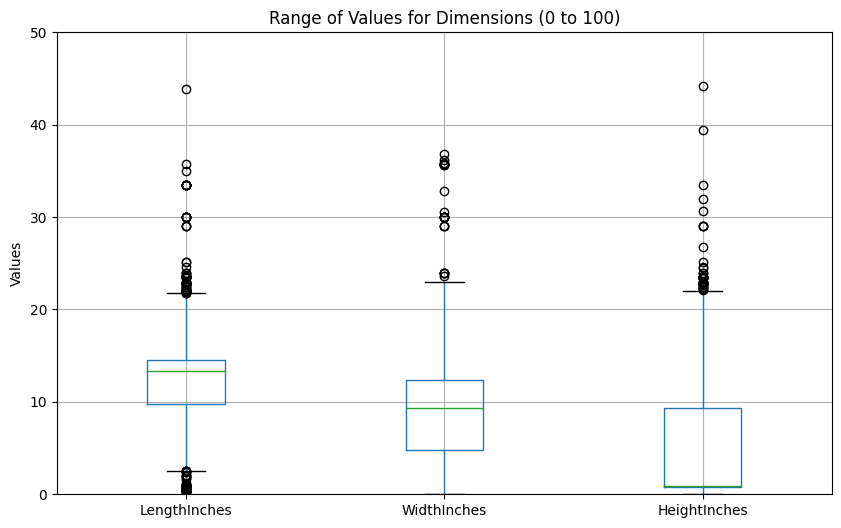

In [8]:
def extract_dimensions_and_weight(dimensions_str):
    if pd.isnull(dimensions_str):
        return None, None, None, None
    
    # Define regular expression pattern to capture dimensions and weight
    pattern_dimensions = r'(?P<length>[\d.]+)\s*x\s*(?P<width>[\d.]+)\s*x\s*(?P<height>[\d.]+)\s*inches'
    pattern_weight = r'(?P<weight>[\d.]+)\s*(?:kg|g)'
    
    # Match pattern in the dimensions string
    match_dimensions = re.match(pattern_dimensions, dimensions_str)
    match_weight = re.search(pattern_weight, dimensions_str)
    
    if match_dimensions:
        length_inches = float(match_dimensions.group('length'))
        width_inches = float(match_dimensions.group('width'))
        height_inches = float(match_dimensions.group('height'))
    else:
        # If dimensions are not specified in inches, try to convert to inches
        pattern_cm = r'(?P<length>[\d.]+)\s*x\s*(?P<width>[\d.]+)\s*x\s*(?P<height>[\d.]+)\s*cm'
        match_cm = re.match(pattern_cm, dimensions_str)
        if match_cm:
            length_cm = float(match_cm.group('length'))
            width_cm = float(match_cm.group('width'))
            height_cm = float(match_cm.group('height'))
            
            # Convert dimensions from cm to inches
            length_inches = length_cm * 0.393701  # 1 cm = 0.393701 inches
            width_inches = width_cm * 0.393701
            height_inches = height_cm * 0.393701
        else:
            return None, None, None, None
    
    # Extract weight if present
    if match_weight:
        weight = float(match_weight.group('weight'))
        
        # Convert weight to kilograms if it's specified in grams
        if 'kg' in dimensions_str:
            weight_kgs = weight
        else:
            weight_kgs = weight / 1000  # 1 gram = 0.001 kilograms
    else:
        weight_kgs = None
        
    return length_inches, width_inches, height_inches, weight_kgs

df[['LengthInches', 'WidthInches', 'HeightInches', 'DimensionsKg']] = df['Product Dimensions'].apply(extract_dimensions_and_weight).apply(pd.Series)

# Set the size of the figure
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the width and height as needed

# Create boxplots for the subset of columns
boxplot = df[['LengthInches', 'WidthInches', 'HeightInches']].boxplot(ax=ax)  # Exclude outliers

# Set y-axis limit to focus on the range of interest
ax.set_ylim(0, 50)

# Set plot labels and title
ax.set_ylabel('Values')
ax.set_title('Range of Values for Dimensions (0 to 100)')

# Show plot
plt.show()

### Similar Columns in the Dataset:

- **`RAM` & `RAM Size`:** We merged the columns and reduced the number of NaN values.

- **`Processor Speed` & `Processor Type`:** They had similar values and we were able to extract the relevant information.

- **`Memory Technology`:** Simiplified to `DDR#` to reduce the complexity.

- **`Grphic Chipset Brand` & `Graphic Card Manufacturer`:** We merged the columns and reduced the number of NaN values.


In [9]:
df = pd.read_csv("./data/csv/clean_V1.csv")
df.sample(2)

,Price,Title,RAM,Hard Drive,Graphics Coprocessor,Number of USB 3.0 Ports,Brand,Series,Operating System,Processor Brand,Item model number,Graphics Card Ram Size,Manufacturer,Form Factor,Processor Type,Processor Speed,Memory Technology,Hard Disk Description,Graphics Chipset Brand,DisplaySizeInches,HorizontalPixels,VerticalPixels,WeightKg,Refurbished,base_color
170,1074.332,Oemgenuine OEM Dell Latitude 3540 Notebook 15....,16 GB DDR4,512 GB SSD,Intel Iris Xe Graphics,0,Oemgenuine,Latitude 3540,Windows 11 Pro,Intel,Latitude 3540,16 GB,Dell,Notebook,Core i5,2.4 GHz,other,NaN,Intel,15.6,1920.0,1080.0,1.791688,0,other
4201,479.840,(Refurbished) HP 840g3 Elitebook Ultralight 1....,16 GB,16 GB,Intel HD Graphics,0,HP,840g3,Windows,Intel,840g3i5-cr,1,HP,Laptop,Core i5 6200U,2.4 GHz,other,HDD,Intel,14.0,1366.0,768.0,1.500000,1,Silver


#### Unique Values:

In [10]:
# Create a dictionary to store the number of unique values for each column
unique_values_dict = {}

# Iterate over columns and count unique values
for i in df.columns:
    unique_values_dict[i] = len(df[i].unique())

# Create a DataFrame from the dictionary
unique_values_df = pd.DataFrame(list(unique_values_dict.items()), columns=['Column', 'Number of Unique Values'])

# Sort the DataFrame by the number of unique values in descending order
unique_values_df = unique_values_df.sort_values(by='Number of Unique Values', ascending=False)
horizontal_df = unique_values_df.set_index('Column').T

print("Number of Unique values:\n")
(horizontal_df)


Number of Unique values:



Column,Title,Item model number,Price,Series,WeightKg,Graphics Coprocessor,Processor Type,RAM,Brand,Manufacturer,Hard Drive,Processor Speed,Operating System,DisplaySizeInches,HorizontalPixels,Graphics Card Ram Size,Form Factor,Hard Disk Description,VerticalPixels,Processor Brand,base_color,Graphics Chipset Brand,Number of USB 3.0 Ports,Memory Technology,Refurbished
Number of Unique Values,5568,3381,2920,2335,691,339,235,207,152,149,129,117,95,71,48,46,46,32,31,22,19,13,8,5,2


In [11]:
print("Total number of Null Values in the dataset:", df.isnull().sum().sum())

Total number of Null Values in the dataset: 7254


#### Handling the Dataset: 


#### **Simplifying the Categories:**
- **Storage:**

    | SSD | HDD | Other |
    |-----|-----|-------|

<br>

- **Graphic Processor:** 

    | Intel | NVIDIA | AMD | Apple | Other |
    |-------|--------|-----|-------|-------|

<br>

- **Operating System:** 

    | Windows | MAC | Other |
    |-------|--------|-----|
<br>

- **CPU Processor Brand:** 

    | Intel | AMD Ryzen # | Other |
    |-------|--------|-----|

<br>

- **Processor Series:** 

    | Intel i# | AMD | Other |
    |-------|--------|-----|



<br>

- **Form Factor:** 

    | Laptop | Portable | Gaming | Netbook | Chromebook |  Other |
    |-------|--------|-----|-------|-------|-----|

<br>

- **Processor Speed:** Standardized into `#GHz`

In [12]:
df = pd.read_csv("./data/csv/clean_V2.csv")
df.sample(2)

,Price,Title,Number of USB 3.0 Ports,Brand,Series,Processor Brand,Item model number,Memory Technology,Hard Disk Description,Graphics Chipset Brand,DisplaySizeInches,HorizontalPixels,VerticalPixels,WeightKg,Refurbished,base_color,RAM_in_GB,Graphics_Coprocessor_Brand,OS_Name,MANU_Name,Graphics Storage (GB),Laptop_Type,ProcessorManufacturer,ProcessorSpeedGHz
4139,1199.984,"HP Envy x360, Ryzen 7 7730U, 15.6-inch (39.6 c...",2,HP,15-fh0019AU,AMD,15-fh0019AU,other,SSD,AMD,39.6,1920.0,1080.0,2.14,0,Black,16.0,AMD,Windows,hp,6,Portable,AMD RYZEN 7,4.5
3097,599.984,"HP Laptop 15, 12th Gen Intel® Core™ i3-1215U,1...",0,HP,15s-fq5327TU,Intel,HP,ddr4,SSD,Intel,15.6,1920.0,1080.0,1.69,0,Silver,16.0,Intel,Windows,hp,6,Laptop,Intel I3,4.4


In [13]:
print("Total number of Null Values in the dataset:", df.isnull().sum().sum())

Total number of Null Values in the dataset: 0


We dropped a few additional columns which were repeating as we had already used them to fill the other columns.

We converted the columns to match the data types and improve the storage efficiency.

In [14]:
df['Price'] = df['Price'].round().astype(int)
df['RAM_in_GB'] = df['RAM_in_GB'].astype(int)


### Correlation of Numerical Features With Price

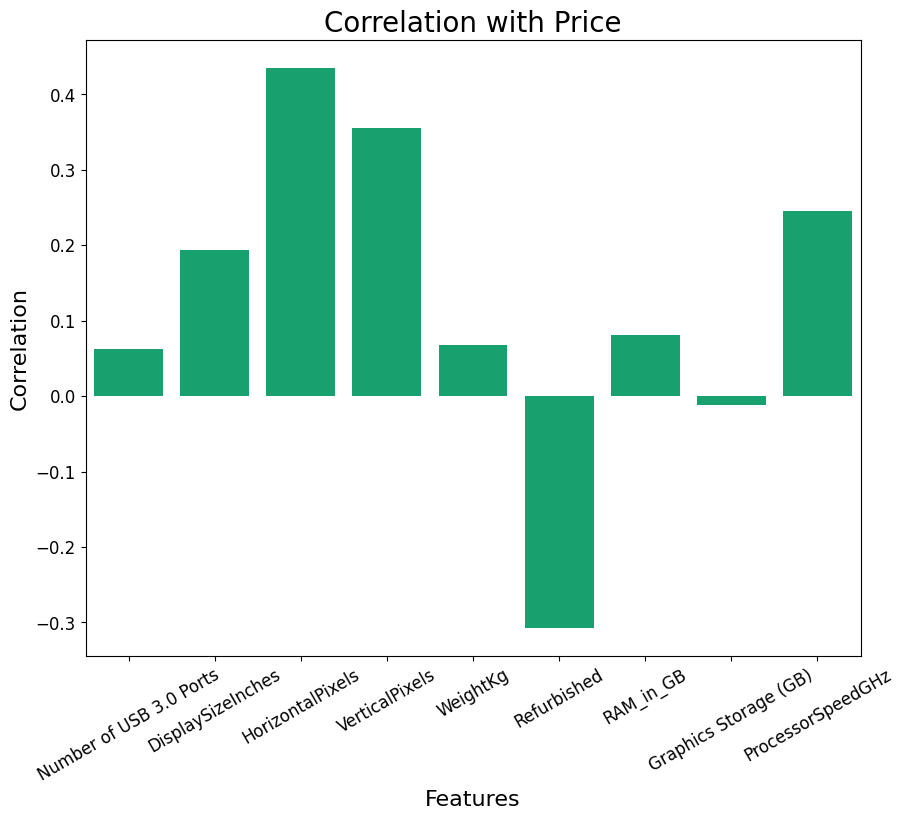

In [15]:
numeric_columns = df.select_dtypes(include=['number']).drop(columns=['Price'])

# Calculate correlation of numeric columns with respect to 'Price' column
correlation_with_price = numeric_columns.corrwith(df['Price'])

plt.figure(figsize=(10, 8))  # Increase the size of the figure
sns.barplot(x=correlation_with_price.index, y=correlation_with_price.values, color=(2/255, 182/255, 118/255, 255/255))
plt.title('Correlation with Price', fontsize=20)  # Increase title font size
plt.xlabel('Features', fontsize=16)  # Increase x-label font size
plt.ylabel('Correlation', fontsize=16)  # Increase y-label font size
plt.xticks(rotation=30, fontsize=12)  # Increase x-ticks font size and rotate them for better readability
plt.yticks(fontsize=12)  # Increase y-ticks font size
plt.show()

<Axes: xlabel='Price', ylabel='Density'>

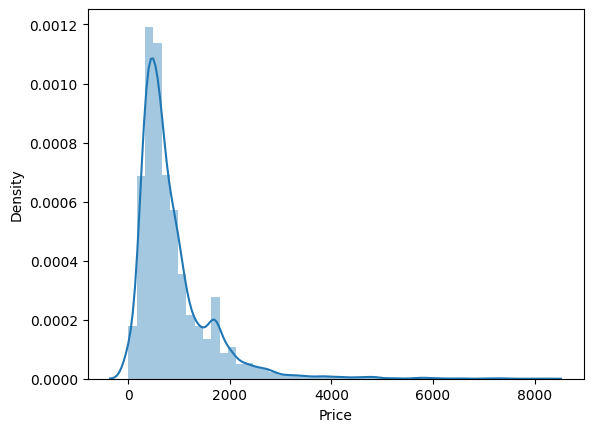

In [16]:
sns.distplot(df['Price'])

In [17]:
df['Brand'] = df['Brand'].str.lower().replace(['asus computer intl'], ['asus'])
df["Brand"] = df["Brand"].str.capitalize()

In [18]:
def plot_dual_bar(filtered_df, x_column, y1_column, y2_column, title='', ax=None):
    # Apply transformations to the DataFrame

    # Create a dictionary to map brand names to colors
    # brand_colors = {brand: 'blue' for brand in filtered_df['Brand'].unique()}
    # Plotting
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the first bar plot
    sns.barplot(x=filtered_df[x_column], y=filtered_df[y1_column], ax=ax, color=(2/255, 182/255, 118/255, 255/255), label=y1_column)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=18)
    ax.set_ylabel(y1_column, fontsize=14)

    # Plot the second bar plot with shared x-axis
    ax2 = ax.twinx()
    counts = filtered_df[x_column].value_counts()
    ax2.bar(counts.index, counts.values, color='black', alpha=0.7, width=0.5, label=y2_column)  # Adjust width here
    ax2.set_ylabel(y2_column, fontsize=14)

    # Add legend
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc='upper right')

    # Increase font size of y-axis values
    ax.tick_params(axis='y', labelsize=12)  # Increase font size for y-axis values of ax
    ax2.tick_params(axis='y', labelsize=12)

    ax.set_xlabel(x_column, fontsize=14)
    ax.set_title(title, fontsize = 20)

In [19]:
df.head(1)

,Price,Title,Number of USB 3.0 Ports,Brand,Series,Processor Brand,Item model number,Memory Technology,Hard Disk Description,Graphics Chipset Brand,DisplaySizeInches,HorizontalPixels,VerticalPixels,WeightKg,Refurbished,base_color,RAM_in_GB,Graphics_Coprocessor_Brand,OS_Name,MANU_Name,Graphics Storage (GB),Laptop_Type,ProcessorManufacturer,ProcessorSpeedGHz
0,815,"HP 17 Laptop i5-1235U, 512 GB SSD, 16GB RAM, 1...",2,Hp,HP 17T,Intel,HP,other,SSD,Other,17.3,1600.0,900.0,2.381358,0,Silver,16,Intel,Windows,hp,512,Laptop,Other,3.0


In [20]:
values_brand = df['Brand'].value_counts()
filtered_brands = values_brand[values_brand > 100].index
filtered_df_brand = df[df['Brand'].isin(filtered_brands)]

values_color = df['base_color'].value_counts()
filtered_color = values_color[values_color > 80].index
filtered_df_color = df[df['base_color'].isin(filtered_color)]

In [21]:
filtered_df.head(1)

,Title,Standing screen display size,Screen Resolution,Processor,RAM,Hard Drive,Graphics Coprocessor,Number of USB 3.0 Ports,Brand,Series,Operating System,Item Weight,Product Dimensions,Processor Brand,Batteries,Item model number,Graphics Card Ram Size,Manufacturer,Colour,Form Factor,Processor Type,Processor Speed,RAM Size,Memory Technology,Hard Drive Size,Hard Disk Description,Graphics Chipset Brand,Graphics Card Description,Graphics RAM Type,Country of Origin
1862,"Dell 14 Laptop, 12th Gen Intel Core i3-1215U P...",14 Inches,1920*1080,NaN,NaN,NaN,INTEGRATED,2.0,Dell,Vostro 3420,Windows 11 Home,1 kg 480 g,22 x 32.3 x 1.9 cm; 1.48 kg,Intel,1 Lithium Ion batteries required. (included),Vostro 14,2 GB,Dell,Dark Silver,laptop,Core i3 Family,0.9 GHz,8 GB,DDR4,512 GB,SSD,Intel,Integrated,Shared,China


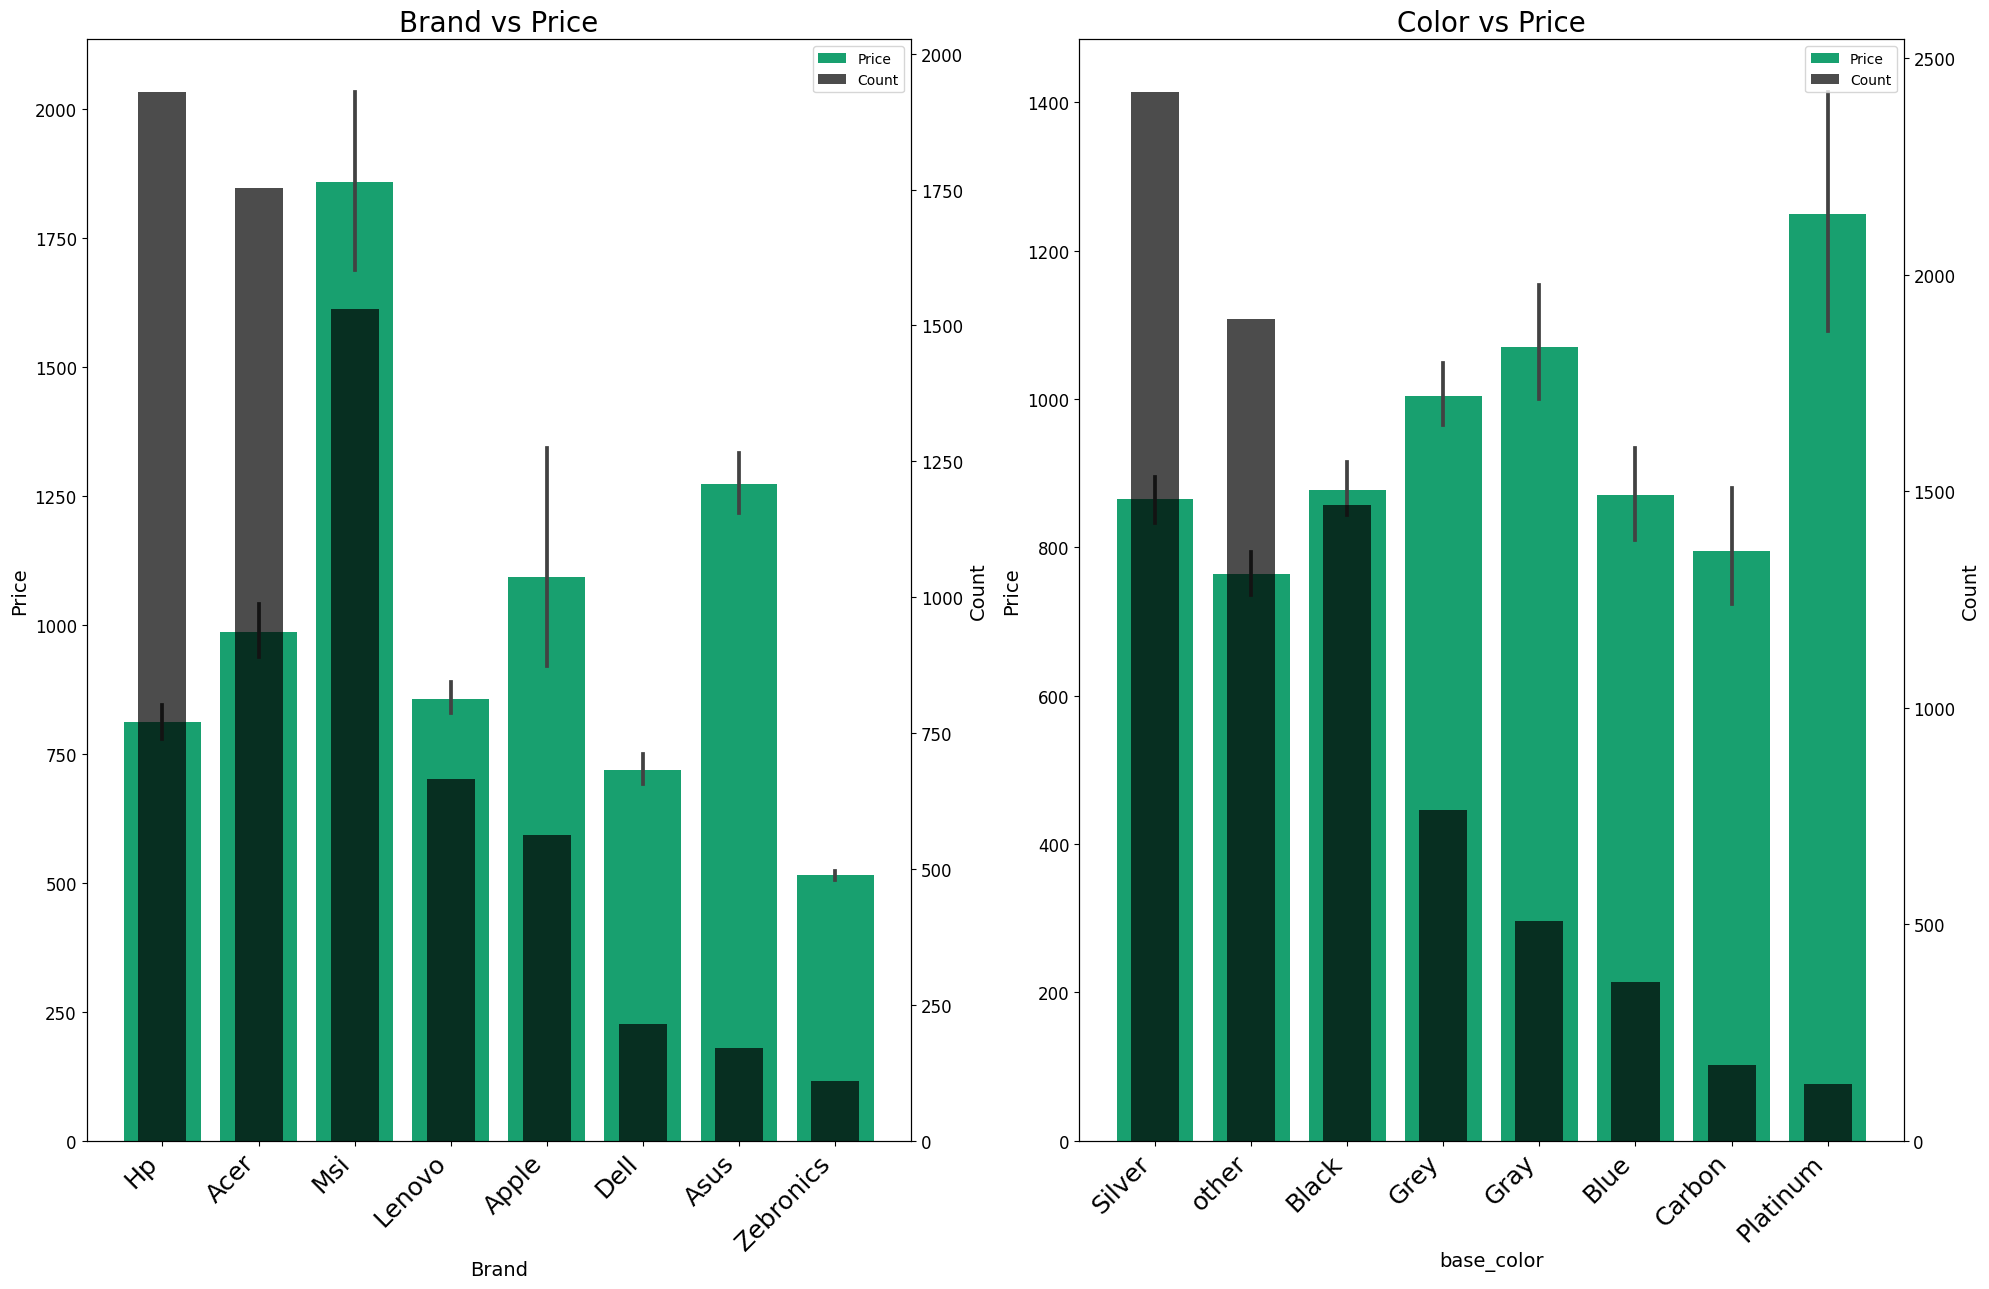

In [166]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 13))
plot_dual_bar(filtered_df_brand, 'Brand', 'Price', 'Count', "Brand vs Price", ax=axes[0])
plot_dual_bar(filtered_df_color, 'base_color', 'Price', 'Count', "Color vs Price", ax=axes[1])

plt.tight_layout()
plt.show()

| Category             | Most Sold            | Most Expensive  |
|----------------------|----------------------|----------------------|
| **Brand**              | HP, Acer, MSI        | MSI, Asus, Apple     | 
| **Color** | Silver, Others, Black| Platinum, Grey, Black|


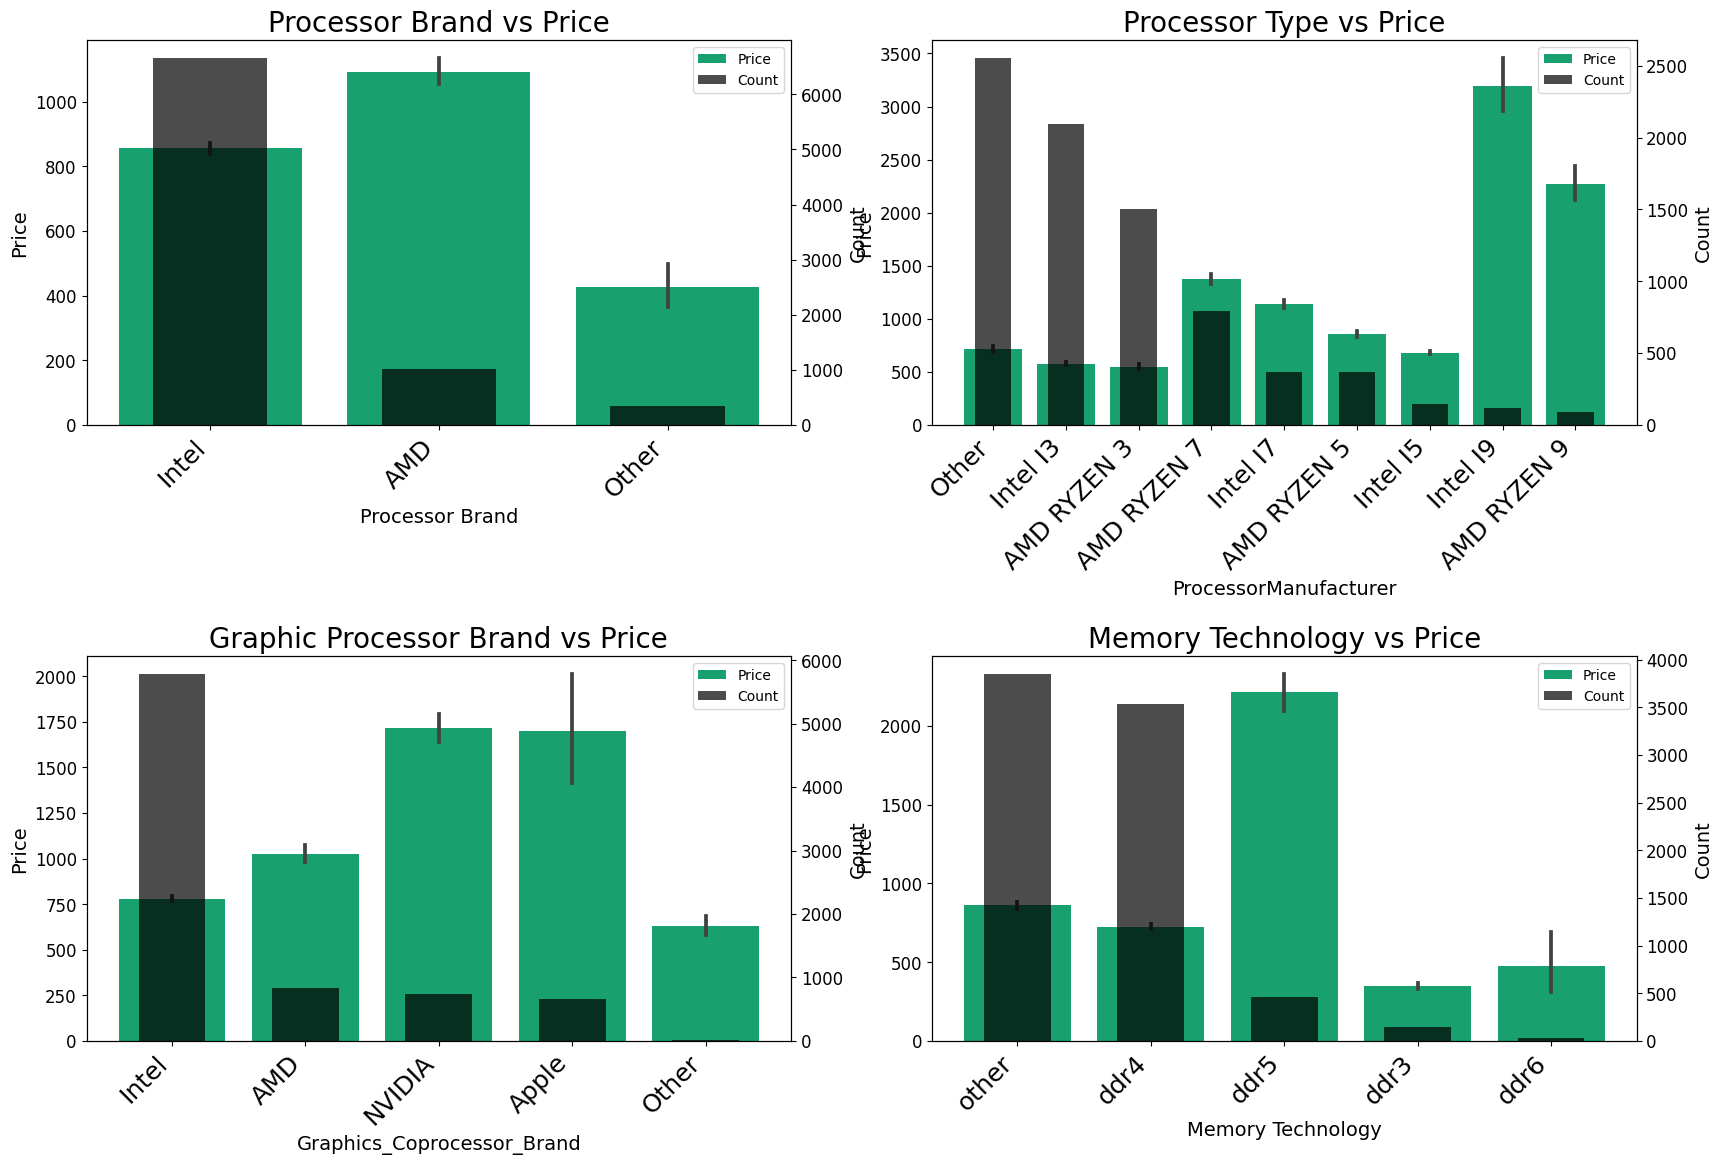

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 13), gridspec_kw={'hspace': 0.6})

plot_dual_bar(df, 'Processor Brand', 'Price', 'Count',  "Processor Brand vs Price", ax=axes[0, 0])
plot_dual_bar(df, 'ProcessorManufacturer', 'Price', 'Count', "Processor Type vs Price", ax=axes[0, 1])
plot_dual_bar(df, 'Graphics_Coprocessor_Brand', 'Price', 'Count',  "Graphic Processor Brand vs Price", ax=axes[1, 0])
plot_dual_bar(df, 'Memory Technology', 'Price', 'Count',  "Memory Technology vs Price", ax=axes[1, 1])

plt.tight_layout()
plt.show()

| Category             | Most Sold            | Most Expensive  |
|----------------------|----------------------|----------------------|
| **CPU**              | Intel        | AMD    | 
| **CPU Type** | Others | Intel i9 |
| **GPU** | Intel | NVIDIA |
| **Type of Memory** | DDR 4 | DDR 5 |


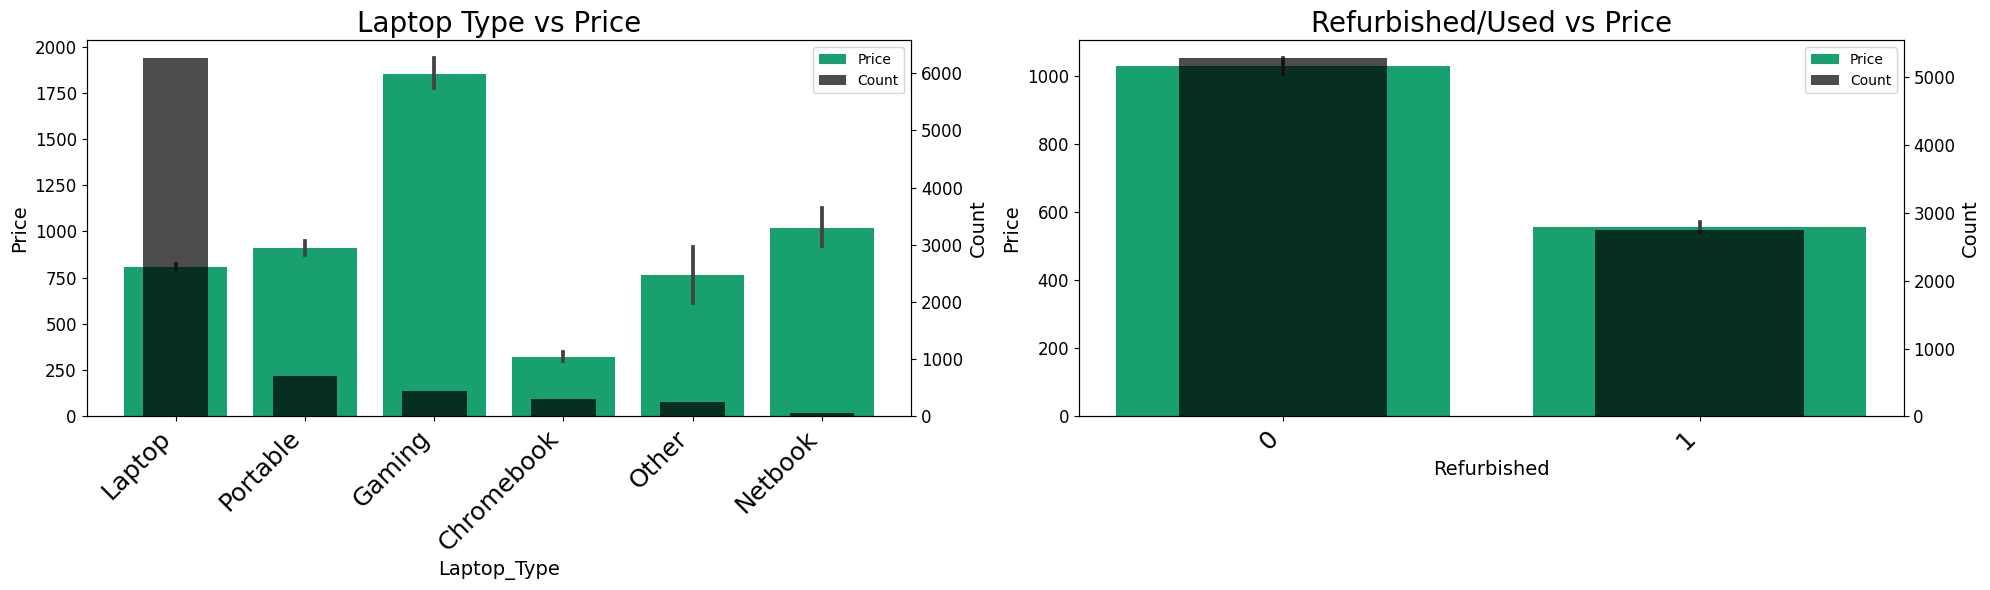

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

plot_dual_bar(df, 'Laptop_Type', 'Price', 'Count', "Laptop Type vs Price", ax=axes[0])
plot_dual_bar(df, 'Refurbished', 'Price', 'Count', "Refurbished/Used vs Price", ax=axes[1])

plt.tight_layout()
plt.show()


- **Laptop Type:**
    - Gaming Laptops are considered to be the most expensive.

    - General Laptops/Notebooks are sold the most.

- **Average Refurbished Pricing:**

    | Refurished | Yes | No |
    |----|----|----|
    |  **Price**  | $575 | $1000|


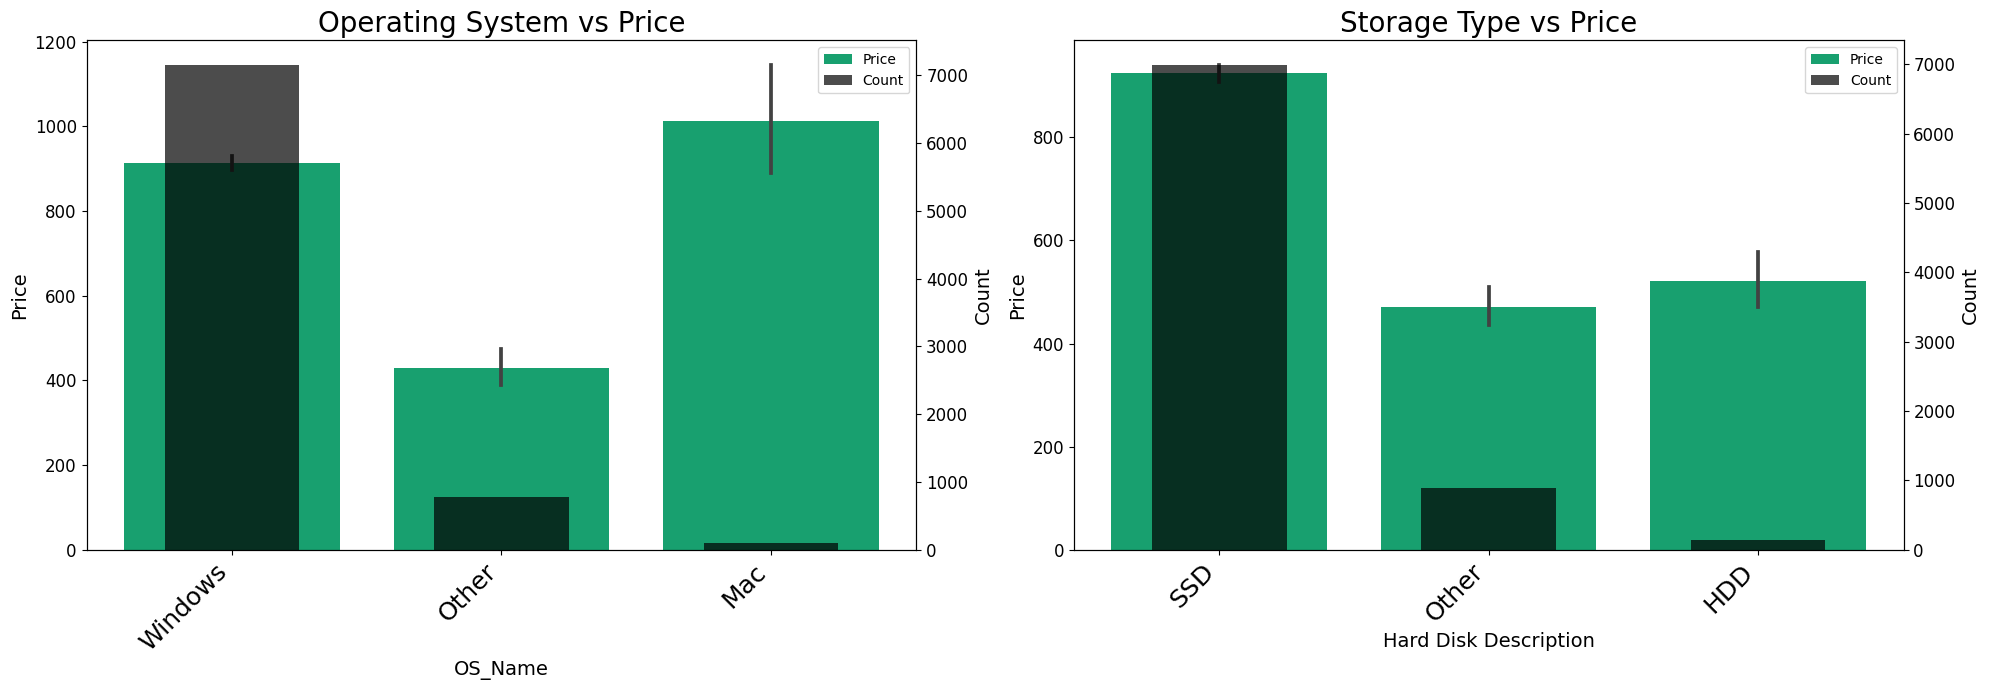

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

plot_dual_bar(df, 'OS_Name', 'Price', 'Count', "Operating System vs Price", ax=axes[0])
plot_dual_bar(df, 'Hard Disk Description', 'Price', 'Count', "Storage Type vs Price", ax=axes[1])

plt.tight_layout()
plt.show()

In [168]:
sns.histplot(df['ProcessorSpeedGHz'], kde=True, color='blue')
plt.xlabel('Processor Speed (GHz)')
plt.ylabel('Density')
plt.title('Distribution of Processor Speed (GHz)')
plt.show()

- **Processor Speed:**
    - Majority of the laptops have a speed between 2GHz and 4 GHz

- **Prices:**
    - The prices of the laptops reach upto $8000

### Applying Boxcox to handle the skewness of Prices

By applying Boxcox, we aim to normalize the data and achieve a normal distribution of the data.

We use inverse boxcox to get back the original data, with the help of lambda value. 

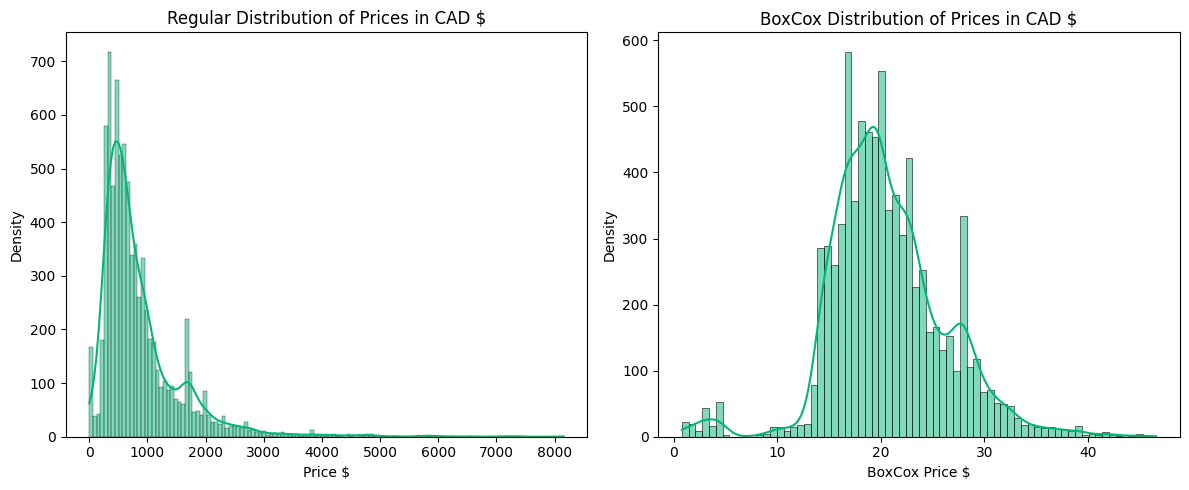

In [30]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
y_transformed, lambda_value = boxcox(df['Price'])

# Plot the first distribution
sns.histplot(df["Price"], kde=True, color=(2/255, 182/255, 118/255, 255/255), ax=axes[0])
axes[0].set_xlabel('Price $')
axes[0].set_ylabel('Density')
axes[0].set_title('Regular Distribution of Prices in CAD $')

# Plot the second distribution
sns.histplot(y_transformed, kde=True, color=(2/255, 182/255, 118/255, 255/255), ax=axes[1])
axes[1].set_xlabel('BoxCox Price $')
axes[1].set_ylabel('Density')
axes[1].set_title('BoxCox Distribution of Prices in CAD $')

# Adjust layout
plt.tight_layout()
plt.show()


In [31]:
print("Number of laptops which cost more than $3500 are:", len(df[df["Price"]>3500]))
df[df["Price"]>3500].sample(2)

Number of laptops which cost more than $3500 are: 102


,Price,Title,Number of USB 3.0 Ports,Brand,Series,Processor Brand,Item model number,Memory Technology,Hard Disk Description,Graphics Chipset Brand,DisplaySizeInches,HorizontalPixels,VerticalPixels,WeightKg,Refurbished,base_color,RAM_in_GB,Graphics_Coprocessor_Brand,OS_Name,MANU_Name,Graphics Storage (GB),Laptop_Type,ProcessorManufacturer,ProcessorSpeedGHz
500,5705,EXCaliberPC [2024] MSI Raider GE78 HX 14VIG-60...,0,Excaliberpc,MSI Raider GE78 HX,Intel,Raider GE78 HX 14VIG-600US,ddr5,SSD,Intel,17.0,2560.0,1600.0,2.998243,0,other,16,NVIDIA,Windows,Other,6,Laptop,Intel I9,1.6
5981,4464,"ASUS ROG Zephyrus G14 (2023) 76WHr Battery, AM...",3,Asus,ROG Zephyrus G14 (2023),AMD,GA402XZ-N2019WS,other,SSD,NVIDIA,14.0,2560.0,1600.0,1.720000,0,White,32,NVIDIA,Windows,asus,12,Laptop,AMD RYZEN 9,5.2


#### Reading the Final Version of the dataset

In [32]:
df = pd.read_csv("./data/csv/final.csv")

## Model Training

#### Splitting the Dataset for Training, Validation and Testing

In [34]:
X = df.drop(columns=['Price', 'Title'])

y_transformed, lambda_value = boxcox(df['Price'])
y_transformed = y_transformed.reshape(-1, 1)



X_train, X_temp, y_train, y_temp = train_test_split(X, y_transformed, test_size = 0.2, random_state = 19)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 19)

print("X Train Shape:", X_train.shape)
print("X Val Shape:", X_val.shape)
print("X Test Shape:", X_test.shape)

X Train Shape: (6420, 18)
X Val Shape: (802, 18)
X Test Shape: (803, 18)


### Defining Transformers for Numerical & Categorical Features:

In [38]:
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
# categorical_features = X.values.tolist()

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

def call_pipeline(preprocessor, model):
    return Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

def evaluate_print(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return r2, mse, mae

def call_cv_search(pipeline, parameters_distribution):
    return RandomizedSearchCV(
        pipeline,
        param_distributions=parameters_distribution,
        n_iter=50,
        scoring='neg_mean_absolute_error',
        cv=5,
        verbose=0,
        random_state=42,
        n_jobs=-1
    )

# Define a learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

best_model = None
best_score = -float('inf')

- Standard Scaler applied to the numerical features.

- One-Hot Encoding for the categorical features.

- Combined the pipelines into a preprocessor.

### Machine Learning Models with Hyperparameters:

#### Random Forest:
- It is a team of decision trees working together. They're trained on different random subsets of the data.
- When we make a prediction, each tree in the forest gives its own prediction, and then the forest takes a vote to decide the final prediction. This helps reduce overfitting and increases accuracy.

####  Support Vector Regression:
- Aims to minimize the distance for a subset of points called support vectors.
- These support vectors are the ones closest to the plane.
- SVR aims to ensure that the errors for these support vectors are within a certain threshold, called the margin.

#### Gradient Boosting:
- We start with a simple model and then iteratively build upon it, each time focusing on the mistakes (gradients) of the previous model and improve our predictions.
- This iterative process helps us create a strong predictive model from many weak ones.

#### XG Boost:
- XGBoost and traditional gradient boosting models work on the same principle of combining weak learners
- It offers several enhancements and optimizations that make it more efficient, scalable and robust.

#### Extra Trees:
- Extra Trees is an ensemble learning technique similar to Random Forests.
- It utilizes increased randomness in split selection, leading to faster training and potentially better generalization.

In [39]:
models = {
    'Linear Regression': (LinearRegression(), {}),
    'Random Forest': (RandomForestRegressor(), {}),
    'Support Vector Regression': (SVR(), {}),
    'Gradient Boosting': (GradientBoostingRegressor(), {}),
    'XGBoost': (xgb.XGBRegressor(), {}),
    'Extra Trees': (ExtraTreesRegressor(), {})
}

#### Pipelines Streamline the process of Preprocessing and combining the algorithms

In [40]:
# Create pipelines for each model
pipelines = {}
for name, (model, params) in models.items():
    pipeline = call_pipeline(preprocessor=preprocessor, model=model)
    pipelines[name] = (pipeline, params)

#### Fitting of Algorithms on our data:

In [41]:
# Fit and evaluate each pipeline
for name, (pipeline, params) in pipelines.items():
    grid_search = GridSearchCV(pipeline, params, scoring='r2', cv=5, verbose=0, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_estimator = grid_search.best_estimator_

    y_val_pred = best_estimator.predict(X_val)
    r2, mse, mae = evaluate_print(y_val, y_val_pred)
    
    print(f"Model: {name}")
    print("R2 Score:", r2)
    print("Mean Squared Error:", mse)
    print("MAE:", mae)
    print()
    
    if r2 > best_score:
        best_score = r2
        best_model = (name, best_estimator)

Model: Linear Regression
R2 Score: 0.7172140703978207
Mean Squared Error: 8.703347314535758
MAE: 2.0131457690659684

Model: Random Forest
R2 Score: 0.8541709347166284
Mean Squared Error: 4.488204223954113
MAE: 1.1535018622842959

Model: Support Vector Regression
R2 Score: 0.7911554782847388
Mean Squared Error: 6.427640900603056
MAE: 1.5470136602558981

Model: Gradient Boosting
R2 Score: 0.78391476384042
Mean Squared Error: 6.650489515111337
MAE: 1.8196050583808114

Model: XGBoost
R2 Score: 0.8433689616678208
Mean Squared Error: 4.820658258206398
MAE: 1.30844277570652

Model: Extra Trees
R2 Score: 0.8432634311575269
Mean Squared Error: 4.823906187425015
MAE: 1.1701196813090717



#### Best Algorithm Without any Hyper-Parameter Tuning

In [42]:
print("Best Model:")
print("Model:", best_model[0])
print("R2 Score:", best_score)
print("Parameters:", best_model[1][1])

Best Model:
Model: Random Forest
R2 Score: 0.8541709347166284
Parameters: RandomForestRegressor()


### Extensive Hyper Parameter Tuning on Ensemble Methods

| regressor Parameters                  | Description                                                           |
|----------------------------|-----------------------------------------------------------------------|
| __n_estimators   | Determines the number of trees in the forest.                         |
| __max_features    | Specifies the maximum number of features for the best split at each node. |
| __max_depth       | Controls the maximum depth of each decision tree.                     |
| __min_samples_split | Number of samples required to split an internal node.     |
| __min_samples_leaf | Number of samples required to be at a leaf node.              |
| __bootstrap       | If set to True, simulated samples are used when building trees.       |
| __learning_rate       | The learning rate controls the contribution of each tree in the ensemble. |
| __subsample           | The fraction of samples used for fitting the individual base learners.   |
| __colsample_bytree    | The fraction of features used for fitting each individual tree.          |
| __gamma               | Minimum loss reduction required to make a further partition on a leaf node of the tree. |
| __reg_alpha           | L1 regularization term on weights.                                        |
| __reg_lambda          | L2 regularization term on weights.                                        |


#### Random Forest


In [43]:
# Create Random Forest pipeline
pipeline_rf = call_pipeline(preprocessor=preprocessor, model=RandomForestRegressor())

# Define hyperparameter grid for Random Forest
param_distribution_rf = {
    'regressor__n_estimators': [int(x) for x in np.linspace(start=150, stop=250, num=10)],
    'regressor__max_features': ['auto', 'sqrt'],
    'regressor__max_depth': [20, 40, 60, 80, None],
    'regressor__min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'regressor__min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'regressor__bootstrap': [True, False]
}

In [44]:
random_search_rf = call_cv_search(pipeline=pipeline_rf, parameters_distribution=param_distribution_rf)

random_search_rf.fit(X_train, y_train)

# Best estimator
best_estimator_rf = random_search_rf.best_estimator_
name = type(best_estimator_rf.named_steps['regressor']).__name__

y_val_pred = best_estimator_rf.predict(X_val)

r2, mse, mae = evaluate_print(y_val, y_val_pred)
print(f"Model: {name}")
print("R2 Score:", r2)
print("Mean Squared Error:", mse)
print("MAE:", mae)
print()
if r2 > best_score:
    best_score = r2
    best_model = (name, best_estimator_rf)

Model: RandomForestRegressor
R2 Score: 0.853989423265918
Mean Squared Error: 4.493790630602143
MAE: 1.1742095370216987



#### XG Boost Regressor

In [45]:
# Create XGBoost pipeline
pipeline_xg = call_pipeline(preprocessor=preprocessor, model=XGBRegressor())

# Define hyperparameter grid for XGBoost
param_distribution_xg = {
    'regressor__n_estimators': [int(x) for x in np.linspace(start=100, stop=200, num=10)],
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5],
    'regressor__max_depth': [3, 4, 5, 6, 8, 10],
    'regressor__subsample': [0.5, 0.7, 0.9, 1.0],
    'regressor__colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    'regressor__gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'regressor__reg_alpha': [0, 0.01, 0.1, 1, 10, 100],
    'regressor__reg_lambda': [0, 0.01, 0.1, 1, 10, 100]
}

In [46]:
random_search_xg = call_cv_search(pipeline=pipeline_xg, parameters_distribution=param_distribution_xg)

random_search_xg.fit(X_train, y_train)

# Best estimator
best_estimator_xg = random_search_xg.best_estimator_
name = type(best_estimator_xg.named_steps['regressor']).__name__

y_val_pred = best_estimator_xg.predict(X_val)

r2, mse, mae = evaluate_print(y_val, y_val_pred)
print(f"Model: {name}")
print("R2 Score:", r2)
print("Mean Squared Error:", mse)
print("MAE:", mae)
print()
if r2 > best_score:
    best_score = r2
    best_model = (name, best_estimator_xg)

Model: XGBRegressor
R2 Score: 0.8725390924960275
Mean Squared Error: 3.922884524677714
MAE: 1.1134943699892406



#### Gradient Boosting Regressor

In [47]:
# Create GradientBoostingRegressor pipeline
pipeline_gb = call_pipeline(preprocessor=preprocessor, model=GradientBoostingRegressor())

# Define hyperparameter grid for GradientBoostingRegressor
param_distribution_gb = {
    'regressor__n_estimators': [100, 200, 300, 400, 500],
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5],
    'regressor__max_depth': [3, 4, 5, 6, 8, 10],
    'regressor__subsample': [0.5, 0.7, 0.9, 1.0],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['auto', 'sqrt', 'log2', None]
}

In [48]:
random_search_gb = call_cv_search(pipeline=pipeline_gb, parameters_distribution=param_distribution_gb)
random_search_gb.fit(X_train, y_train)

# Best estimator
best_estimator_gb = random_search_gb.best_estimator_
name = type(best_estimator_gb.named_steps['regressor']).__name__

y_val_pred = best_estimator_gb.predict(X_val)

r2, mse, mae = evaluate_print(y_val, y_val_pred)
print(f"Model: {name}")
print("R2 Score:", r2)
print("Mean Squared Error:", mse)
print("MAE:", mae)
print()
if r2 > best_score:
    best_score = r2
    best_model = (name, best_estimator_gb)

Model: GradientBoostingRegressor
R2 Score: 0.850296701497051
Mean Squared Error: 4.607442112964111
MAE: 1.183797957003142



#### ExtraTrees Regressor

In [49]:
extra_trees_pipeline = call_pipeline(preprocessor=preprocessor, model=ExtraTreesRegressor())

# Define hyperparameter grid for ExtraTreesRegressor
extra_trees_param_distributions = {
    'regressor__n_estimators': [int(x) for x in np.linspace(start=100, stop=200, num=10)],
    'regressor__max_depth': [None, 3, 5, 7, 9],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__bootstrap': [True, False],
    'regressor__max_features': ['auto', 'sqrt', 'log2', None]
}

In [50]:
random_search_extra_trees = call_cv_search(pipeline=extra_trees_pipeline, parameters_distribution=extra_trees_param_distributions)
random_search_extra_trees.fit(X_train, y_train)

# Best estimator
best_estimator_extra_trees = random_search_extra_trees.best_estimator_
name = type(best_estimator_extra_trees.named_steps['regressor']).__name__

print("Successful with Training of Extra Trees Model!")

y_val_pred = best_estimator_extra_trees.predict(X_val)

r2, mse, mae = evaluate_print(y_val, y_val_pred)
print(f"Model: {name}")
print("R2 Score:", r2)
print("Mean Squared Error:", mse)
print("MAE:", mae)
print()
if r2 > best_score:
    best_score = r2
    best_model = (name, best_estimator_extra_trees)

Successful with Training of Extra Trees Model!
Model: ExtraTreesRegressor
R2 Score: 0.854061721502565
Mean Squared Error: 4.491565496329541
MAE: 1.145477495045513



#### VotingRegressor

In [51]:


# Define the estimators with their best parameters
estimators = [
    ('extra_trees', best_estimator_extra_trees),
    ('gradient_boosting', best_estimator_gb),
    ('xgboost', best_estimator_xg),
    ('random_forest', best_estimator_rf)
]

# Create the VotingRegressor
voting_regressor = VotingRegressor(estimators)

# Fit the VotingRegressor on the training data
voting_regressor.fit(X_train, y_train)

y_val_pred = voting_regressor.predict(X_val)

r2, mse, mae = evaluate_print(y_val, y_val_pred)
print(f"Model: Voting Regressor")
print("R2 Score:", r2)
print("Mean Squared Error:", mse)
print("MAE:", mae)
print()
if r2 > best_score:
    best_score = r2
    best_model = ("Voting Regressor", voting_regressor)

Model: ExtraTreesRegressor
R2 Score: 0.8735700162872598
Mean Squared Error: 3.8911556199810193
MAE: 1.0854307663815643



### Evaluating Ensemble Methods

In [95]:
def evaluate_models(models, X_test, y_test):
    results = {}
    for name, model in models.items():
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        results[name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R-squared': r2}
    return results

In [110]:
def plot_actual_vs_predicted_3d(models, X_test, y_test):
    # Create a DataFrame with actual and predicted values
    data = {'Actual': y_test.flatten(), 'Ensemble': models['Ensemble'].predict(X_test).flatten()}
    for name, model in models.items():
        if name != 'Ensemble':
            data[name] = model.predict(X_test).flatten()
    df = pd.DataFrame(data)

    # Melt the DataFrame to convert model names into a 'Model' column
    df_melted = df.melt(id_vars=['Actual'], var_name='Model', value_name='Predicted')

    # Assign unique colors to each model
    color_map = px.colors.qualitative.Set1[:len(models)]
    color_discrete_map = {model_name: color for model_name, color in zip(models.keys(), color_map)}

    # Plot with Plotly Express
    fig = px.scatter_3d(df_melted, x='Actual', y='Predicted', z='Model', color='Model', color_discrete_map=color_discrete_map)
    fig.update_traces(marker=dict(size=5))
    fig.update_layout(scene=dict(xaxis_title='Actual', yaxis_title='Predicted', zaxis_title='Model'),
                      title='Actual vs. Predicted (3D Scatter Plot)')
    fig.show()

In [169]:
def plot_performance_metrics(results):
    metrics = ['MAE', 'MSE', 'R-squared', 'RMSE']
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    axes = axes.flatten()
    
    best_models = {}
    
    for i, metric in enumerate(metrics):
        values = [result[metric] for result in results.values()]
        models_names = list(results.keys())
        
        # Find the index of the minimum/maximum value for the metric
        if 'MAE' in metric or 'MSE' in metric:  # Lower is better
            best_index = np.argmin(values)
        else:  # Higher is better (for RMSE and R-squared)
            best_index = np.argmax(values)
        
        best_models[metric] = models_names[best_index]
        
        # Plot the bar chart
        sns.barplot(x=models_names, y=values, ax=axes[i], color=(2/255, 182/255, 118/255, 255/255))
        axes[i].set_title(f'{metric} Comparison')
        axes[i].set_xlabel('Model')
        axes[i].set_ylabel(metric)
        
        # Mark the best performing model
        axes[i].plot(best_index, values[best_index], 'ro', markersize=8, label='Best')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()
    
    return best_models

In [121]:
models = {'Random Forest': best_estimator_rf, 'XGBoost': best_estimator_xg, 'Gradient Boosting': best_estimator_gb,
          'Extra Trees': best_estimator_extra_trees, 'Voting Regressor': voting_regressor}

preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

results = evaluate_models(models, X_test, y_test)

In [111]:
plot_actual_vs_predicted_3d(models, X_test, y_test)

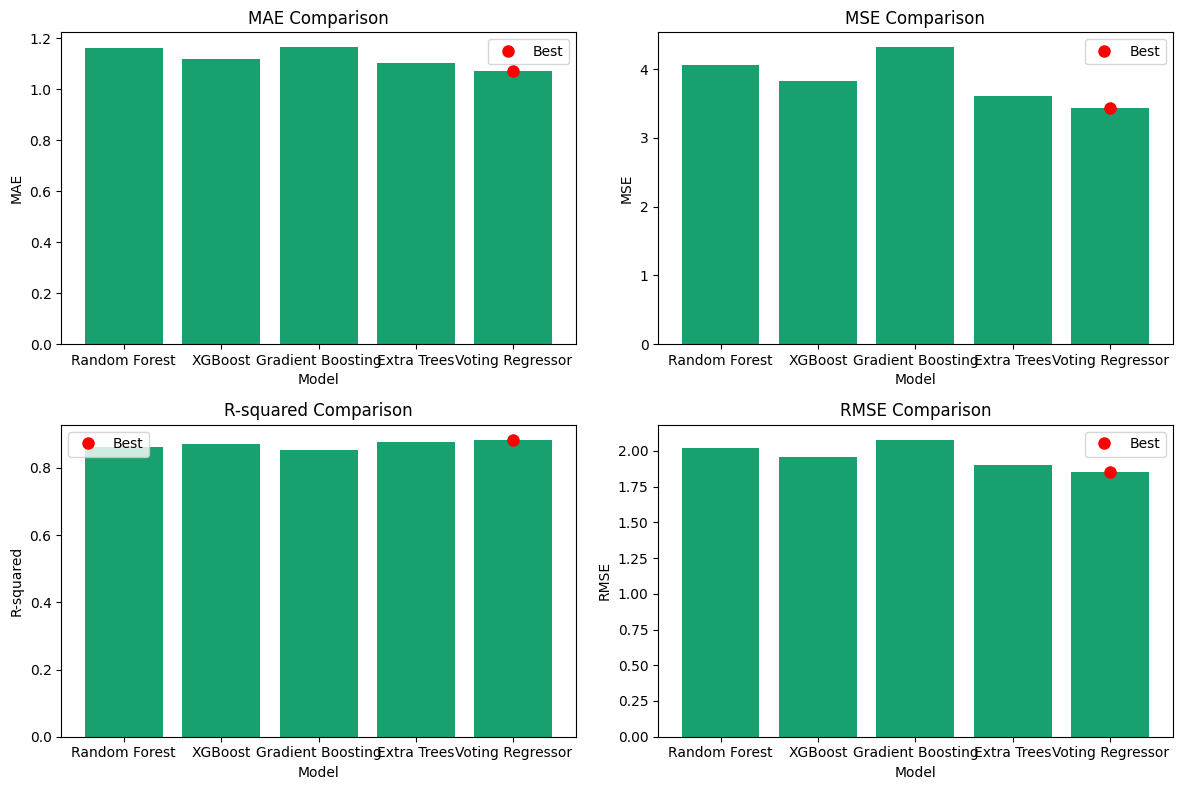

{'MAE': 'Voting Regressor',
 'MSE': 'Voting Regressor',
 'R-squared': 'Voting Regressor',
 'RMSE': 'Voting Regressor'}

In [170]:
plot_performance_metrics(results)

### Best Machine Learning Regressor Algorithm:

In [119]:
print("Best Model:")
print("Model:", best_model[0])
print("R2 Score:", best_score)

Best Model:
Model: Voting Regressor
R2 Score: 0.8735700162872598


## Deep Learning:

### Dense Sequential Neural Networks:

In [137]:
# Apply preprocessing to the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_test_preprocessed = preprocessor.transform(X_test)

# Define the deep learning model with increased complexity
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_preprocessed.shape[1],)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

2024-04-17 04:22:05.709365: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-17 04:22:05.748969: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [138]:
# Create a pipeline to include preprocessing and modeling steps
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [139]:
# Train the pipeline
pipeline.fit(X_train, y_train, model__callbacks=[early_stopping], model__epochs=200, model__batch_size=64, model__validation_split=0.2)

X_val_preprocessed = pipeline['preprocessor'].transform(X_val)
y_val_pred = pipeline['model'].predict(X_val_preprocessed)

r2, mse, mae = evaluate_print(y_val, y_val_pred)
print(f"Model: {model}")
print("R2 Score:", r2)
print("Mean Squared Error:", mse)
print("MAE:", mae)

if r2 > best_score:
    best_score = r2
    best_model = ("Dense Neural Network - 512 Layers", model)

Epoch 1/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 212.9955 - val_loss: 21.0690
Epoch 2/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 34.2393 - val_loss: 12.8423
Epoch 3/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 27.3643 - val_loss: 13.3734
Epoch 4/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 23.4631 - val_loss: 10.9924
Epoch 5/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 21.8461 - val_loss: 17.7470
Epoch 6/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 21.4311 - val_loss: 13.2097
Epoch 7/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.4799 - val_loss: 21.4566
Epoch 8/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 20.8431 - val_loss: 23.9135
Epoch 9/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.9144 - val_loss: 10.7706
Epoch 10/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 18.5422 - val_loss: 12.3111
Epoch 11/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 17.7462 - val_loss: 10.3258
Epoch 12/200
81/81 ━━━━━━━━━━

- R2 Score: 0.828
- Mean Squared Error: 5.29
- Mean Absolute Error: 1.50

### 2. Dense Sequential Neural Network

In [140]:
model = Sequential([
    Dense(1024, activation='relu', input_shape=(X_train_preprocessed.shape[1],)),
    Dropout(0.1),  # Adding dropout after this layer
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1)  # Output layer with one neuron for regression
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

# Train the model with callbacks
history = model.fit(X_train_preprocessed, y_train, 
                    validation_data=(X_val_preprocessed, y_val), 
                    epochs=100, batch_size=10, verbose=1, 
                    callbacks=[early_stopping, lr_scheduler_callback])

Epoch 1/100
642/642 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 69.7786 - val_loss: 8.4840 - learning_rate: 0.0010
Epoch 2/100
642/642 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 9.3488 - val_loss: 8.2540 - learning_rate: 0.0010
Epoch 3/100
642/642 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 7.7757 - val_loss: 6.4656 - learning_rate: 0.0010
Epoch 4/100
642/642 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 6.8045 - val_loss: 9.5781 - learning_rate: 0.0010
Epoch 5/100
642/642 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 7.0274 - val_loss: 6.1876 - learning_rate: 0.0010
Epoch 6/100
642/642 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 6.6625 - val_loss: 6.7780 - learning_rate: 0.0010
Epoch 7/100
642/642 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 6.5875 - val_loss: 8.3356 - learning_rate: 0.0010
Epoch 8/100
642/642 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 6.0034 - val_loss: 6.5297 - learning_rate: 0.0010
Epoch 9/100
642/642 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 5.5268 - val_loss: 5.8493 - learning_rat

In [141]:
y_pred = model.predict(X_val_preprocessed)

r2, mse, mae = evaluate_print(y_val, y_pred)
print(f"Model: {model}")
print("R2 Score:", r2)
print("Mean Squared Error:", mse)
print("MAE:", mae)

if r2 > best_score:
    best_score = r2
    best_model = ("Dense Neural Network - 1k Layers", model)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Model: <Sequential name=sequential_1, built=True>
R2 Score: 0.8490256765422598
Mean Squared Error: 4.6465606491747105
MAE: 1.3490300665240553


- R2 Score: 0.849
- Mean Squared Error: 4.646
- Mean Absolute Error: 1.349

## Model Evaluations

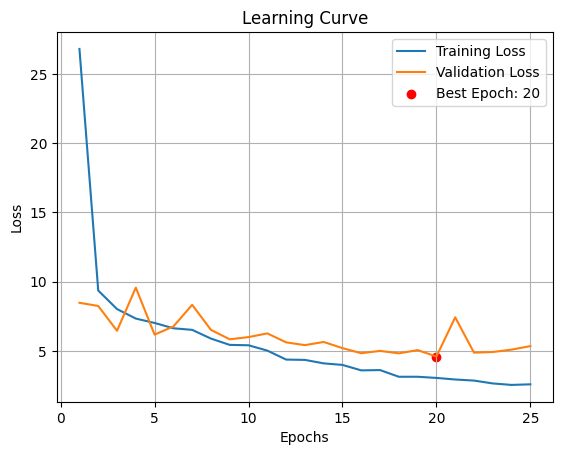

In [144]:
best_epoch = history.history['val_loss'].index(min(history.history['val_loss'])) + 1

plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], label='Training Loss')
plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], label='Validation Loss')
plt.scatter(best_epoch, history.history['val_loss'][best_epoch - 1], color='red', label=f'Best Epoch: {best_epoch}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()


## Performance Analysis of Machine Learning Model

### Overview
- **X-axis**: Number of epochs, representing iterations over the dataset.
- **Y-axis**: Loss, a metric indicating model performance, where lower values signify better performance.
- **Lines**: 
  - Training loss (blue)
  - Validation loss (orange)
- **Observations**:
  - Training loss sharply decreases initially, then gradually decreases, indicating learning from the training data.
  - Validation loss decreases with fluctuations, suggesting variability in model generalization.
  - 'Best Epoch: 20' marked in red represents the epoch with the lowest validation loss, indicating the model's peak performance on the validation dataset.

### Analysis
- **Training Progress**: The model effectively learns from the training data, as evidenced by the decreasing training loss.
- **Generalization**: Validation loss decreases overall, but with fluctuations.
- **Best Performance**: Epoch 20 appears to be the most successful, with the lowest validation loss.
- **Overfitting**: However, a slight spike in validation loss around epoch 20 indicating potential overfitting if the trend persists.
- **Overall Assessment**: Up to epoch 25, the model learns effectively without significant signs of overfitting or underfitting.

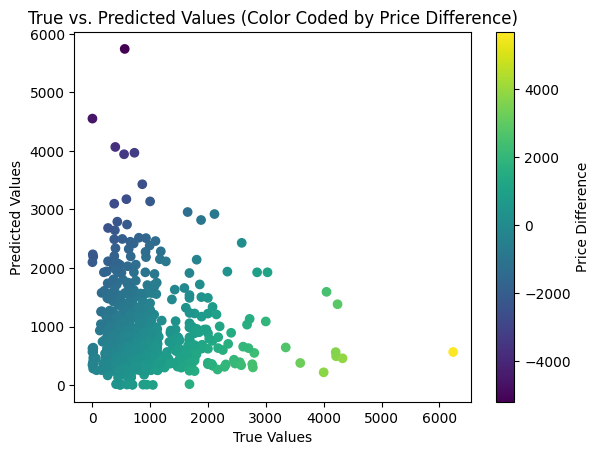

In [150]:
# Reshape predictions array to match the shape of y_test
predictions = y_pred.squeeze()

# Ensure both arrays have the same number of elements
if len(y_test) > len(predictions):
    y_test = y_test[:-1]
elif len(predictions) > len(y_test):
    predictions = predictions[:-1]

# Calculate residuals
residuals = y_test - predictions

# Calculate the price difference
y_test_inv = inv_boxcox(y_test, lambda_value)
predictions_inv = inv_boxcox(predictions, lambda_value)
diff = y_test_inv - predictions_inv

# Plot the scatter plot with dual-color coding
plt.scatter(y_test_inv, predictions_inv, c=diff, cmap='viridis')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values (Color Coded by Price Difference)')
plt.colorbar(label='Price Difference')
plt.show()


## Analysis of Regression Model Predictions

### Overview
The provided scatter plot visualizes the relationship between true values and predicted values generated by the neural network. It allows us to analyze the accuracy and variability of the model's predictions.

### Graph Description
- **X-axis**: True values, representing actual observations from the dataset.
- **Y-axis**: Predicted values, outputs of the regression model.
- **Scatter Plot**:
  - Each point represents an individual prediction, positioned based on the true and predicted values.
  - Color coding indicates the price difference, with a scale provided for interpretation (-4000 to +4000). Negative values imply under-predictions, while positive values suggest over-predictions.
  - A perfect prediction aligns all points along the line y = x, representing equality between predicted and true values.

### Analysis
- **Clustering**: Points concentrate in the lower left corner, suggesting higher accuracy for lower true values.
- **Variability**: As true and predicted values increase, the scatter widens, indicating decreased prediction accuracy and increased variability.
- **Prediction Errors**: 
  - Spread of points above and below the perfect prediction line signifies errors.
  - Colors indicate a mix of overestimations (positive values) and underestimations (negative values) by the model.
- **Extreme Errors**:
  - Purple points denote large negative price differences, indicating significant under-predictions, especially for high true values.
  - Yellow and light green points signify significant over-predictions, particularly for high true values.

### Conclusion
The scatter plot reveals the model's performance across a range of true values. While it demonstrates accuracy for lower values, it exhibits variability and notable errors, particularly for high true values.

In [152]:
# Reshape predictions array to match the shape of y_test
predictions = y_pred.squeeze()

# Ensure both arrays have the same number of elements
if len(y_test) > len(predictions):
    y_test = y_test[:-1]
elif len(predictions) > len(y_test):
    predictions = predictions[:-1]

# Calculate the price difference
y_test_inv = inv_boxcox(y_test, lambda_value)
predictions_inv = inv_boxcox(predictions, lambda_value)
diff = y_test_inv - predictions_inv

# Create a DataFrame
data = {
    'True Values': y_test_inv,
    'Predicted Values': predictions_inv,
    'Price Difference': diff
}
df = pd.DataFrame(data)

# Plot the scatter plot in 3D using Plotly Express
fig = px.scatter_3d(df, x='True Values', y='Predicted Values', z='Price Difference',
                    color='Price Difference', opacity=0.8, color_continuous_scale='viridis',
                    title='True vs. Predicted Values',
                    labels={'True Values': 'True Values', 'Predicted Values': 'Predicted Values',
                            'Price Difference': 'Price Difference'})

# Show the plot
fig.show()


### Analysis of Predicted vs. True Values with Price Difference

#### Graph Overview
The graph illustrates the relationship between predicted and true values of a model, alongside the corresponding price differences.

#### Axes Description
- **Horizontal Plane (X-Y)**:
  - X-axis: Predicted Values
  - Y-axis: True Values (label partially visible)
  - These axes facilitate comparison between model predictions and observed results.
- **Vertical Axis (Z-axis)**:
  - Represents Price Difference, indicating variance between predicted and true values.
  - Zero denotes perfect prediction, positive values signify overestimation, and negative values denote underestimation.

#### Dot Representation
- Each dot corresponds to a single data point.
- Position on the X-Y plane reflects the relationship between predicted and true values.
- Height represents the magnitude of price difference.
- Dot Color:
  - Dark purple: Large negative differences
  - Greens: Small to moderate differences
  - Yellow: Large positive differences
  - Color scale likely aligns with the previous 2D plot.

#### Observations
- Concentration of dark green dots around zero on the vertical axis suggests many predictions closely match true values.
- Purple dots at the bottom indicate significant underpredictions by the model.
- Yellow dot at the top signifies a substantial overprediction by the model.

In [184]:
residuals = y_test_inv - predictions_inv
residuals_df = pd.DataFrame({'True Values': y_test_inv,
                              'Predicted Values': predictions_inv,
                              'Residuals': residuals})

mean_residuals = residuals_df['Residuals'].mean()

# Calculate the plane equation parameters (assuming a plane equation of the form: ax + by + cz + d = 0)
# For the mean plane, as it's parallel to the x-y plane, c = 0
a = 0
b = 0
c = 1  # z-component of the normal vector of the plane
d = -mean_residuals  # Intercept

# Define the range for x and y values to create the plane
x_range = [min(residuals_df['True Values']), max(residuals_df['True Values'])]
y_range = [min(residuals_df['Predicted Values']), max(residuals_df['Predicted Values'])]
x_values = [x_range[0], x_range[1]]
y_values = [y_range[0], y_range[1]]
xx, yy = np.meshgrid(x_values, y_values)
zz = (-a * xx - b * yy - d) / c  # Solve for z

# Add plane to the figure
fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5, colorscale='Viridis', showscale=False))

# Add vertical lines from each point to the mean
for i, row in residuals_df.iterrows():
    fig.add_scatter3d(x=[row['True Values'], row['True Values']],
                      y=[row['Predicted Values'], row['Predicted Values']],
                      z=[row['Residuals'], mean_residuals],
                      mode='lines',
                      line=dict(color='gray', width=1),
                      showlegend=False)

# Show mean line
fig.add_scatter3d(x=[min(residuals_df['True Values']), max(residuals_df['True Values'])],
                  y=[min(residuals_df['Predicted Values']), max(residuals_df['Predicted Values'])],
                  z=[mean_residuals, mean_residuals],
                  mode='lines',
                  line=dict(color='green', width=4),
                  name='Mean Residuals')

fig.show()


### Regression Model Performance Visualization

#### Axes
- **X-axis**: True Values, representing the actual observed values.
- **Y-axis**: Predicted Values, representing the values predicted by a regression model.
- **Z-axis**: Residual/Predicted Value, indicating residual values for each prediction (calculated as true value minus predicted value).

#### Color Scale
- **Range**: -4000 to 4000
- **Visualization**:
  - Blue: Negative residuals (underpredictions)
  - Red: Positive residuals (overpredictions)
  - Green: Near-zero residuals (accurate predictions)

#### Data Points
- Each point represents a prediction made by the model.
- **Blue Points**: Below the horizontal plane, indicating underpredictions.
- **Red Points**: Above the horizontal plane, indicating overpredictions.
- **Green Points**: At the horizontal plane, indicating accurate predictions with minimal residual.

#### Model Performance
- Most predictions are close to the zero residual plane, indicating a good number of accurate predictions.
- **Exceptions**:
  - Some red points indicate significant overpredictions.
  - Some blue points indicate underpredictions.

#### Outliers
- Prominent Points:
  - Large red dot: Indicates significant overprediction.
  - Large blue dot: Indicates significant underprediction.
  - These outliers highlight instances where the model's predictions deviate significantly from actual values.

In [155]:
print("Best Model:")
print("Model:", best_model[0])
print("R2 Score:", best_score)

Best Model:
Model: Voting Regressor
R2 Score: 0.8735700162872598


In [160]:
y_test_pred = voting_regressor.predict(X_test)

y_test_pred = y_test_pred.squeeze()

# Ensure both arrays have the same number of elements
if len(y_test) > len(y_test_pred):
    y_test = y_test[:-1]
elif len(y_test_pred) > len(y_test):
    y_test_pred = y_test_pred[:-1]

# Now you can proceed with evaluating the performance
r2, mse, mae = evaluate_print(y_test, y_test_pred)
print(f"Performance of Voting Regressor on test data:")
print("R2 Score:", r2)
print("Mean Squared Error:", mse)
print("MAE:", mae)


Performance of Voting Regressor on test data:
R2 Score: 0.8845338645865964
Mean Squared Error: 3.427441816121008
MAE: 1.0679789250993188


In [161]:
joblib.dump(voting_regressor, './models/voting_regressor_model.pkl')

['./models/voting_regressor_model.pkl']

## Conclusions:

Finally we conclude that the `Voting Regressor` is the best ensemble algorithm gives us an R-Squared Score of 0.884. Internally, the Algorithm learns from the following:
- Random Forest Trees
- XG Boost
- Gradient Boost
- Extra Trees

As a naive approach, we used linear regression to evaluate the most simplest approach to this problem and we got a score of 0.70 and our ensemble algorithms perform significantly better than it. Hence this was a success.

We saved the model and the dataset as a `.pkl` file, allowing us to export it and use it in the deployment phase, for which we used StreamLit. The Link for the application is: [Laptop Price Predictor](https://paras-rupani-laptop-price-predictor.streamlit.app)

## References
* Inspired by the Kaggle Dataset provided by [Muhammet Varli](https://www.kaggle.com/datasets/muhammetvarl/laptop-price).
* Comprehensive Kaggle Notebook by [Ludovico Cuoghi](https://www.kaggle.com/code/ludovicocuoghi/xgboost-optuna-deep-feature-engineering-r2-93)
* Detailed Research Paper on [ResearchGate](https://www.researchgate.net/publication/374120586_Laptop_Price_Prediction_with_Machine_Learning_Using_Regression_Algorithm)